<h1 align="center">École d'Hiver 2018</h1> 
<br/>
<h1 align="center">Tutoriel : Données Catégorielles (MLP)</h1> 


In [0]:
%%bash
# Install dependencies
use_conda=`which conda`
if [ $use_conda ] ; then
  # Jupyter
  conda install --quiet --yes numpy matplotlib pandas
else
  # Colab
  pip3 --quiet install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl torchvision numpy matplotlib pandas
fi

In [1]:
import torch

Pour mener à bien un projet en deep learning, on a besoin de:
<ul>
<li>Une <b> tâche à résoudre</b> ainsi que des <b>données</b> pour la supporter </li>
<li>Un <b>modèle</b> (réseau de neurones) à entraîner </li>
<li>Une <b>fonction de coût</b> à optimiser </li>
<li>Un <b>optimiseur</b> qui ajustera les paramètres (poids) du réseau de neurones</li>
</ul>

## 1) Tâche - Prédiction de la survie suite à un naufrage

Notre objectif est de <b>prédire si un passager a survécu ou non à la suite du naufrage du Titanic</b>.

### a) Le dataset Titanic

Le dataset Titanic peut être téléchargé à l'adresse suivante:  https://github.com/afansi/winterschool18/blob/master/titanic3.csv?raw=true.<br/>
Nous utiliserons le paquet <a href="https://pandas.pydata.org/"> <b> Pandas </b></a>   pour le charger en mémoire de notre ordinateur.

In [2]:
import numpy as np
import pandas as pd

In [3]:
titanic_df = pd.read_csv(
    'https://github.com/afansi/winterschool18/blob/master/titanic3.csv?raw=true',
    sep='\t', 
    index_col=None, 
    na_values=['NA']
)

In [4]:
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### La signification des différentes colonnes (features) est la suivante:

<ol>

  <li> <b>pclass</b>: Classe du Passager (1 = première; 2 = seconde; 3 = troisième) </li>
  <li> <b>survived</b>: Survie (0 = non; 1 = oui) </li>
  <li> <b>name</b>: Nom </li>
  <li> <b>sex</b>: Sexe </li>
  <li> <b>age</b>: Âge </li>
  <li> <b>sibsp</b>: Nombre de frères, sœurs, ou conjoints à bord </li>
  <li> <b>parch</b>: Nombre de parents ou enfants à bord </li>
  <li> <b>ticket</b>: Numéro de ticket </li>
  <li> <b>fare</b>: Tarif passager </li>
  <li> <b>cabin</b>: Numéro de cabine </li>
  <li> <b>embarked</b>: Port d'embarquement (C = Cherbourg; Q = Queenstown; S = Southampton) </li>
  <li> <b>boat</b>: Canot de sauvetage (si le passager a survécu) </li>
  <li> <b>body</b>: Numéro de corps (si le passager n'a pas survécu et que son corps a été retrouvé) </li>
  <li> <b>home.dest</b>: la destination du passager </li>
 </ol>


### b) Comprendre son jeu de données : Prétraitement du dataset

### Questions: 

<b> a) Y'a t'il des features sans aucune utilité pour la tâche à accomplir? Si oui, lesquelles et pourquoi ? <br/>
<br/>
<b> b) Un réseau de neurones ne sait manipuler que des données numériques. Cependant, certaines features importantes pour la tâche définie sont non-numériques. Lesquelles? Devez-vous exclure ces features du jeu de données? Si oui, pourquoi? Si non, comment les passeriez-vous à un réseau de neurones?</b><br/>


 
 Le dataset pré-processé peut être téléchargé à l'adresse suivante:  https://github.com/afansi/winterschool18/blob/master/titanic_prepocess.xls?raw=true.

In [5]:
titanic_preprocess_df = pd.read_csv(
    'https://github.com/afansi/winterschool18/blob/master/titanic_prepocess.csv?raw=true', 
    sep=',', 
    index_col=None
)

In [6]:
titanic_preprocess_df.head()

,survived,pclass_1,pclass_2,pclass_3,sex_female,sex_male,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,1,1,0,0,1,0,29.0000,0,0,211.3375,0,0,1
1,1,1,0,0,0,1,0.9167,1,2,151.5500,0,0,1
2,0,1,0,0,1,0,2.0000,1,2,151.5500,0,0,1
3,0,1,0,0,0,1,30.0000,1,2,151.5500,0,0,1
4,0,1,0,0,1,0,25.0000,1,2,151.5500,0,0,1


### c) Découpage en Train / Validation / Test

En général, le dataset est divisé en trois parties:

<ol>
<li> <b> Train</b> (en général, 60 % du dataset): utilisée pour entraîner le modèle de classification.</li>   
<li> <b> Validation</b> (en général, 20 % du dataset): utilisée pour évaluer les performances du modèle en cours d'entraînement.</li>   
<li> <b> Test</b> (en général, 20 % du dataset): utilisée pour évaluer les performances de généralisation du modèle entraîné. </li>
</ol>

In [7]:
np.random.seed(1234)
train, validate, test = np.split(
    titanic_preprocess_df.sample(frac=1, random_state=134), 
    [int(.6*len(titanic_preprocess_df)), 
     int(.8*len(titanic_preprocess_df))
    ]
)

X_train = train.drop(['survived'], axis=1).values
y_train = train['survived'].values

X_val = validate.drop(['survived'], axis=1).values
y_val = validate['survived'].values

X_test = test.drop(['survived'], axis=1).values
y_test = test['survived'].values

## 2) Modèle: Multi-Layer Perceptrons (MLP)

Pour résoudre notre tâche, nous allons utiliser un MLP avec les caractéristiques suivantes:
 <ul>
 <li> <b> 4 </b> couches (<b> 3 </b> couches cachées et <b> 1 </b> couche de sortie) </li>
 <li> la dimension des données d'entrées est de <b> 12 . </b></li>
 <li> les dimensions des différentes couches sont <b> 20, 40, 20, 2. </b> </li>
 <li> utilisation de la fonction d'activation <b> RELU </b> pour les 3 couches cachées.</li>
 </ul>

### a) Illustration

<img src="https://github.com/afansi/winterschool18/blob/master/figures_tuto.pptx.png?raw=true", width=900,  height=500>

### b) Implémentation du modèle en PyTorch

#### 1 - PyTorch en bref

PyTorch est un paquet Python qui fournit deux fonctionnalités de haut niveau:
<ul>
<li> Opérations sur des tenseurs (comme NumPy) avec support GPU </li>
<li> Réseaux de neurones profonds construits sur un système de <b><a href="http://pytorch.org/docs/master/notes/autograd.html"> différentiation automatique</a></b> appelé  <b> <a href="http://pytorch.org/docs/master/autograd.html#">Autograd </a></b>.</li>
</ul>
<br/>
Voici <a href="http://pytorch.org/docs/master/torch.html"> La documentation principale sur PyTorch </a> et celle relative <a href="http://pytorch.org/docs/master/nn.html"> aux réseaux de neurones </a>.


#### 2 - Détails techniques

<ul>
<li> La classe <b><a href="http://pytorch.org/docs/master/nn.html#module">torch.nn.Module</a></b>: 

    <br/> En PyTorch, tout réseau de neurones doit <b>hériter</b> de cette classe ou de ses descendantes (sous-classes).
    <br/> 
</li>   
<li> La méthode <b>forward</b>: 
    <br/> Toute classe définissant un réseau de neurones doit <b>implémenter</b> la méthode  <b>forward</b>. C'est cette méthode qui définit les opérations effectuées par le réseau de neurones et, le cas échéant, construit le graphe computationnel correspondant.
    <br/> 
</li>  
<li> la classe <b><a href="http://pytorch.org/docs/master/nn.html#torch.nn.Linear">`torch.nn.Linear(in_features, out_features)`</a></b>: 
    <br/> Cette classe implémente <b>une couche de réseau dense</b> sans fonction d'activation à sa sortie. <br/> Elle prend par défaut deux paramètres: 
    <ul>
    <li><b>in_features</b>: la dimension des données en entrée de la couche. </li>
    <li><b>out_features</b>: la dimension des données en sortie de la couche. </li>    
    </ul>
    
</li>
<li> le module <b><a href="http://pytorch.org/docs/master/nn.html#torch-nn-functional">torch.nn.functional</a></b>: 
<br/> Il définit un ensemble de fonctions qui peuvent être appliquées aux sorties des différentes composantes d'un réseau de neurones. On y retrouve par example:
    <ul>
    <li> des fonctions non-lineaires: <b><a href="http://pytorch.org/docs/master/nn.html#id36">sigmoid</a></b>, <b><a href="http://pytorch.org/docs/master/nn.html#id35">tanh</a></b>, <b><a href="http://pytorch.org/docs/master/nn.html#id22">relu</a></b>, <a href="http://pytorch.org/docs/master/nn.html#non-linear-activation-functions">etc...</a> </li> 
    <li> des fonctions de coûts: <b><a href="http://pytorch.org/docs/master/nn.html#mse-loss">mse_loss</a></b>, <b><a href="http://pytorch.org/docs/master/nn.html#nll-loss">nll</a></b>, <b><a href="http://pytorch.org/docs/master/nn.html#cross-entropy">cross_entropy</a></b>, <a href="http://pytorch.org/docs/master/nn.html#id42">etc ...</a> </li> 
    <li> des fonctions de régularisation: <b><a href="http://pytorch.org/docs/master/nn.html#id38">droupout</a></b>, <a href="http://pytorch.org/docs/master/nn.html#dropout-functions">etc ...</a>  </li> 
    <li> <a href="http://pytorch.org/docs/master/nn.html#torch-nn-functional">et plein encore ...</a> </li> 
    </ul>
    <br/> 
</li>
<li> la classe <b><a href="http://pytorch.org/docs/master/autograd.html#variable">torch.autograd.Variable</a></b>: 
    <br/> Pour faire simple, cette classe permet <b>d'encapsuler</b> les données à faire ingérer par un réseau de neurones. C'est à travers elle que tout le mécanisme de <b><a href="http://pytorch.org/docs/master/notes/autograd.html">diférentiation automatique</a></b> s'effectue. 
</li>
</ul>

#### 3 - Implémentation

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(1234)

#### Exercice: 

Compléter la classe NeuralNet afin de satisfaire aux contraintes du réseau de neurones telles que décrites.

In [10]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()        
        self.fc1 = nn.Linear(12, 20)
        self.fc2 = nn.Linear(20, 40)
        self.fc3 = nn.Linear(40, 20)
        self.fc4 = nn.Linear(20, 2)
        
        # À Completer avec la définition d'autres couches .....
        

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        # À Completer avec l'appel à d'autres couches .....
        return x

### c) Datasets en PyTorch

PyTorch offre plusieurs utilitaires pour faciliter le traitement des données, rendant ainsi le code plus lisible. <br/> Un de ces utilitaires est la classe <b><a href="http://pytorch.org/docs/master/data.html#"> Dataset (torch.utils.data.Dataset)</a> </b> et ses sous-classes qui offrent une interface facile d'utilisation pour manipuler un dataset.<br/>
Pour plus d'informations, veuillez vous reportez aux urls suivantes: 
<ul>
<li>http://pytorch.org/docs/master/data.html</li>
<li>http://pytorch.org/tutorials/beginner/data_loading_tutorial.html</li>
</ul>
<br/>
Nous utiliserons la sous-classe <b><a href="http://pytorch.org/docs/master/data.html#"> TensorDataset</a> </b> qui permet d'encapsuler ensemble les features et la target d'un jeu de données. Nous encapsulerons les données de Train, Validation, et Test définies dans la section précédente.


In [11]:
import torch.utils.data

train_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train).float(), 
    torch.from_numpy(y_train).long()
)


#### Exercice: 

Définissez en PyTorch les datasets pour les données de Validation et de Test.

In [12]:
# À compléter

val_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_val).float(), 
    torch.from_numpy(y_val).long()
)

test_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_test).float(), 
    torch.from_numpy(y_test).long()
)

### d) Exécution d'un réseau de neurones

Dans cette section, nous exécuterons notre réseau de neurones sur des données aloitoirement générées. 

<b>Important à savoir:</b>
    En PyTorch, il existe deux modes d'exécution d'un réseau de neurones:
    <ul>
    <li> <b>train</b>: dans ce mode, tous les mécanismes d'apprentissage (construction du graphe computationnel, auto-différentiation) sont mis en place à chaque exécution du réseau. Il est utilisé lorsque le réseau est en cours d'entraînement.</li>
    <li> <b>eval</b>: dans ce mode, aucun mécanisme d'apprentissage est mis en place. On dit aussi que le modèle est en mode <b>inférence</b>. Il est utilisé lorsque le réseau est en cours d'évaluation.</li>
    </ul>
<br/>    
Nous utiliserons le mode <b>eval</b> dans cette section.

In [13]:
from torch.autograd import Variable

In [14]:
# Instantiation du réseau
neural_net = NeuralNet()

In [15]:
# activation du mode eval
neural_net = neural_net.eval()

In [16]:
# Sélection des 5 premières données du dataset de validation
data, target = val_dataset[0:5]

In [17]:
# Encapusaulation des données dans la classe Variable
data = Variable(data)
target = Variable(target)

In [18]:
# Execution du réseau de neurones
output = neural_net(data)   
# neural_net.forward(data)

In [19]:
# Tranformation des resultat en probabilités en utilisant la fonction SOFTMAX
output_proba = F.softmax(output, dim=1)

In [20]:
# Affichage des probabilités
print(output_proba)

Variable containing:
 0.5176  0.4824
 0.3129  0.6871
 0.3483  0.6517
 0.4888  0.5112
 0.4927  0.5073
[torch.FloatTensor of size 5x2]



Les lignes définissent la sortie du réseau, en terme de <b> probabilités sur deux classes</b>, <b>mort</b> (0 - 1ere colonne) ou <b>survie</b> (1 - 2nde colonne), pour chacune des 5 données en entrée.

In [21]:
# Affichage des prédictions (classe ayant la plus grande probabilités)
_, prediction = torch.max(output_proba, dim=1)
print(prediction)

Variable containing:
 0
 1
 1
 1
 1
[torch.LongTensor of size 5]



In [22]:
# Affichage de la vrai target
print(target)

Variable containing:
 0
 0
 1
 0
 1
[torch.LongTensor of size 5]



### Questions: 

<b> Que constatez vous ? </b> <br/>
<b> Et pourquoi? </b>

## 3) Fonction de coût et Optimiseur

### a) Fonction de coût

La fonction de coût doit être définie en fonction de la tâche que nous souhaitons réaliser.

PyTorch offre <a href="http://pytorch.org/docs/master/nn.html#id42">une multitude de fonctions de coûts</a> prêtes à l'emploi.

Pour des problèmes de classification, la fonction de coût usuelle est <b> l'entropie croisée (cross-entropy)</b> et c'est elle que nous allons utiliser dans ce tutoriel. En PyTorch, elle est définie par la fonction <b><a href="http://pytorch.org/docs/master/nn.html#cross-entropy">`torch.nn.functional.cross_entropy`</a></b>. 

In [23]:
import torch.nn.functional as F


def cost_function(prediction, target):
    loss = F.cross_entropy(prediction, target)
    return loss

### b) Rétro-propagation du gradient

En Pytorch, grâce au mécanisme de differentiation automatique <a href="http://pytorch.org/docs/master/notes/autograd.html">Autograd</a>, il est possible de calculer automatiquement le gradient de la fonction de coût et de le rétro-propager à travers le graphe computationnel.

Pour ce faire, une fois la fonction de coût calculée et stockée dans une variable, il suffit d'appeler la méthode <b> backward() </b> de cette dernière.<br/>

#### Snippet de rétro-propagation:

loss = fonction_de_cout(...) <br/>
loss.backward()<br/>

### c) Optimiseur

PyTorch fournit un <a href="http://pytorch.org/docs/master/optim.html#algorithms">ensemble de méthodes d'optimisation</a> couramment utilisées dans la communauté de Deep Learning. Parmi ces méthodes, on y retrouve notamment: 
<ul>
<li><b>SGD</b> (Stochastic Gradient Descent)</li>
<li><b>Adam</b> (Adaptive Moment Estimation): variante de la méthode de descente de gradient dans laquelle le taux d'apprentissage est ajusté pour chaque paramètre. Cet ajustement est basé sur le momentum (moyenne glissante des gradients) et la courbure (moyenne glissante de la dérivée seconde). Cet optimiseur a démontré de très bonnes performamces par rapport à SGD dans la litérature.</li>
<li>...</li>
</ul>



Pour pouvoir utiliser un optimiseur en PyTorch, il faut l'instancier en lui passant les éléments suivants:
<ul>
<li><b>les paramètres du réseau de neurones</b>: ceux-ci s'obtiennent à l'aide de la methode <b>parameters()</b> sur le modèle instanciée.</li>
<li><b>le learning rate (lr)</b>: c'est le taux d'apprentissage à utiliser pour la mise à jour des paramètres du réseau de neurones pendant le processus d'optimization.</li>
<li>D'autres paramètres propres à l'optimiseur choisi...</li>
</ul>


PyTorch offre un interface simplifiée pour interagir avec tout optimiseur:
<ul>
<li><b>zero_grad()</b>: Permet d'effacer les gradients des paramètres du réseau de neurones à optimiser. Elle est appelée <b>au début d'une étape d'optimisation</b> afin de re-initialiser les infos sur les paramètres à optimiser. </li>
<li><b>step()</b>: Permet d'effectuer une étape d'optimisation. Elle est appelée <b>après une étape de rétro-propagation du gradient</b>.</li>
</ul>

Dans ce tutoriel, nous utiliserons <b>SGD</b> avec une <b>lr</b> de 0.001.

In [41]:
import torch.optim as optim


#optimizer = optim.SGD(neural_net.parameters(), lr=0.001) 
optimizer = optim.Adam(neural_net.parameters(), lr=0.001) 

## 4) Entraînement

### a) Epoch, Itération, Mini-batch

#### Définitions: 
<ol>
<li>
<b>Epoch</b> : une passe complète sur tout le dataset d'entraînement.
</li>

<li>
<b>Itération</b> : une mise à jour des paramètres du modèle (réseau de neurones). De nombreuses itérations peuvent se produire avant la fin d'un epoch.
</li>

<li>
<b>Mini-batch</b> : Ensemble de données utilisées pour effectuer une mise à jour des paramètres du modèle. Autrement dit, à chaque itération, un mini-batch est utilisé. 
</li>

</ol>



#### Mini-batch en PyTorch: 

<ul>
<li>
PyTorch offre un utilitaire appelé <b><a href="http://pytorch.org/docs/master/data.html"> torch.utils.data.DataLoader </a></b> permettant de charger un dataset quelconque et de le découper automatiquement en mini-batchs.
</li>
</ul>

#### Bon à savoir: 

<ul>
<li>
Lors de l'entraînement, il est important que les données présentées au réseau apparaissent dans <b> un ordre différent d'un epoch à l'autre</b>.
</li>
</ul>

#### Définissons à présent les dataloaders pour nos trois datasets (Train, Validation, et Test)

In [25]:
train_batch_size = 32  # nombre de données dans un batch d'entraînement.
eval_batch_size = 32   # nombre de données dans un batch d'évaluation.


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)

test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False)

### b) Boucle principale

Nous définissons ici notre procédure d'entraînement pour un epoch.

#### Exercice: 

Completez la procédure "train".

In [26]:
def train(epoch, model, train_loader, optimizer):
    
    # mettre le modèle en mode train
    model = model.train()
    
    # Accumulateurs d'informations
    total_loss = 0
    correct = 0
    
    # itérer sur les mini-batchs
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # encapsuler les données dans la classe Variable
        data, target = Variable(data), Variable(target)
        
        # mettre à zéro les gradients des paramètres du réseau de neurones
        optimizer.zero_grad()
        
        # exécuter le réseau de neurones sur les données du mini-batch
        prediction = model(data)
        
        # calculer la fonction de coût par rapport à la target
        loss = cost_function(prediction, target)
        
        # faire la retro-propagation du gradient
        loss.backward()
        
        # effectuer un étape d'optimisation
        optimizer.step()
        
        # effectuer la somme des coûts
        total_loss += loss.data[0]*len(data)
        
        # calculer le nombre de bonnes prédictions 
        # (classe correspondante à la valeur maximale en sortie)        
        pred_classes = prediction.data.max(1, keepdim=True)[1]
        correct += pred_classes.eq(target.data.view_as(pred_classes)).sum()
        
    # calculer le coût moyen par epoch
    mean_loss = total_loss/len(train_loader.dataset)
    
    # calculer l'acurracy
    acc = correct / len(train_loader.dataset)
        
    print('Train Epoch: {}   Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        epoch, mean_loss, correct, len(train_loader.dataset),
        100. * acc))   
    
    # retourner le coût moyen obtenu
    return mean_loss, acc

### c) Procédure d'évaluation

Nous définissons ici notre procédure d'évaluation du modèle.

#### Exercice: 

Completez la procédure "eval".

In [27]:
def eval(model, eval_loader):
    
    # mettre le modèle en mode eval
    model = model.eval()
    
    # Accumulateurs d'informations
    total_loss = 0
    correct = 0
    
    # itérer sur les mini-batchs
    for batch_idx, (data, target) in enumerate(eval_loader):
        
        # encapsuler les données dans la classe Variable
        data, target = Variable(data), Variable(target)
        
         # exécuter le réseau de neurones sur les données du mini-batch
        prediction = model(data)
        
        # calculer la fonction de coût par rapport à la target
        loss = cost_function(prediction, target)
        
        # effectuer la somme des coûts
        total_loss += loss.data[0]*len(data)
        
        # calculer le nombre de bonnes prédictions 
        # (classe correspondante à la valeur maximale en sortie)
        pred_classes = prediction.data.max(1, keepdim=True)[1]
        correct += pred_classes.eq(target.data.view_as(pred_classes)).sum()
    
    # calculer le coût moyen
    mean_loss = total_loss/len(eval_loader.dataset)
    
    # calculer l'acurracy
    acc = correct / len(eval_loader.dataset)
        
    print('Eval:  Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        mean_loss, correct, len(eval_loader.dataset),
        100. * acc)) 
    
    # retourner le coût moyen obtenu
    return mean_loss, acc

### d) Checkpointing

Pour des phases d'entraînement qui requièrent beaucoup de temps, il est recommandé de sauvegarder les paramètres (poids) du réseau de neurones au fil de l'apprentissage. C'est ce que l'on appelle communément le <b> checkpointing</b>.

PyTorch offre <a href="http://pytorch.org/docs/master/notes/serialization.html">un mécanisme simple</a> pour effectuer cette opération. 





Nous implémentons ici deux méthodes:
<ul>
<li> la première pour <b> sauvegarder </b> un réseau de neurones </li>
<li> la seconde pour <b> charger </b> une sauvegarde de réseau de neurones </li>
</ul>

In [28]:
def save_model(epoch, model, path='./'):
    
    # creation du nom de fichier indexé par la valeur de l'epoch
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # sauvegarde des paramètres du modèle.
    torch.save(model.state_dict(), filename)
    
    
    return model
    

In [29]:
def load_model(epoch, model, path='./'):
    
    # creation du nom de fichier indexé par la valeur de l'epoch
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # chargement des paramètres du modèle sauvegardé.
    model.load_state_dict(torch.load(filename))
    
    
    return model

#### Important à savoir:  

Il est également possible de sauvegarder <b>l'état de l'optimiseur</b> en PyTorch. Ceci est très important dans les situations où nous souhaitons reprendre l'entraînement du réseau de neurones à partir d'une sauvegarde donnée. Pour plus d'informations, veuillez consulter l'url suivante: https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610/3

### e) Entraînement

#### Exercice: 

Completez les zones en pointillés (...).

In [42]:
# nombre d'epochs
numEpochs = 200

# Frequence de sauvegarde
checkpoint_freq = 10

# Repertoire pour la sauvegarde des données
path = './'

# Accumulateurs des coûts moyens obtenu par epoch
train_losses = []
val_losses = []

# Accumulateurs des performances par epoch
train_accuracies = []
val_accuracies = []

# Itérer sur le nombre d'epochs
for epoch in range(1, numEpochs + 1):
    
    # entraîner le modèle avec le dataset de train
    train_loss, train_acc = train(epoch, neural_net, train_loader, optimizer)
    
    # évaluer le modèle avec le dataset de validation
    val_loss, val_acc = eval(neural_net, val_loader) 
    
    # Sauvegarde des coûts obtenus
    train_losses.append(train_loss)    
    val_losses.append(val_loss)
    
    # Sauvegarde des performamces
    train_accuracies.append(train_acc)    
    val_accuracies.append(val_acc)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, neural_net, path='./')

# Sauvegarde du modèle à la fin de l'entraînement.
save_model(epoch, neural_net, path='./')
    
print("\n\n\nOptimization ended.\n")    


Train Epoch: 1   Avg_Loss: 0.62369   Acc: 419/625 (67.040%)
Eval:  Avg_Loss: 0.62345   Acc: 139/209 (66.507%)
Train Epoch: 2   Avg_Loss: 0.60086   Acc: 428/625 (68.480%)
Eval:  Avg_Loss: 0.59839   Acc: 143/209 (68.421%)
Train Epoch: 3   Avg_Loss: 0.59174   Acc: 441/625 (70.560%)
Eval:  Avg_Loss: 0.60398   Acc: 146/209 (69.856%)
Train Epoch: 4   Avg_Loss: 0.58378   Acc: 445/625 (71.200%)
Eval:  Avg_Loss: 0.58215   Acc: 149/209 (71.292%)
Train Epoch: 5   Avg_Loss: 0.57783   Acc: 445/625 (71.200%)
Eval:  Avg_Loss: 0.58467   Acc: 147/209 (70.335%)
Train Epoch: 6   Avg_Loss: 0.57009   Acc: 447/625 (71.520%)
Eval:  Avg_Loss: 0.56226   Acc: 155/209 (74.163%)
Train Epoch: 7   Avg_Loss: 0.55970   Acc: 452/625 (72.320%)
Eval:  Avg_Loss: 0.54078   Acc: 158/209 (75.598%)
Train Epoch: 8   Avg_Loss: 0.54482   Acc: 468/625 (74.880%)
Eval:  Avg_Loss: 0.52028   Acc: 158/209 (75.598%)
Train Epoch: 9   Avg_Loss: 0.52090   Acc: 468/625 (74.880%)
Eval:  Avg_Loss: 0.50772   Acc: 158/209 (75.598%)
Train Epoc

Train Epoch: 83   Avg_Loss: 0.41148   Acc: 518/625 (82.880%)
Eval:  Avg_Loss: 0.40867   Acc: 166/209 (79.426%)
Train Epoch: 84   Avg_Loss: 0.42018   Acc: 514/625 (82.240%)
Eval:  Avg_Loss: 0.42465   Acc: 165/209 (78.947%)
Train Epoch: 85   Avg_Loss: 0.41590   Acc: 517/625 (82.720%)
Eval:  Avg_Loss: 0.42027   Acc: 169/209 (80.861%)
Train Epoch: 86   Avg_Loss: 0.40931   Acc: 520/625 (83.200%)
Eval:  Avg_Loss: 0.41937   Acc: 167/209 (79.904%)
Train Epoch: 87   Avg_Loss: 0.40935   Acc: 519/625 (83.040%)
Eval:  Avg_Loss: 0.41238   Acc: 169/209 (80.861%)
Train Epoch: 88   Avg_Loss: 0.41144   Acc: 521/625 (83.360%)
Eval:  Avg_Loss: 0.41089   Acc: 170/209 (81.340%)
Train Epoch: 89   Avg_Loss: 0.42134   Acc: 522/625 (83.520%)
Eval:  Avg_Loss: 0.46025   Acc: 166/209 (79.426%)
Train Epoch: 90   Avg_Loss: 0.42879   Acc: 516/625 (82.560%)
Eval:  Avg_Loss: 0.47104   Acc: 164/209 (78.469%)
Train Epoch: 91   Avg_Loss: 0.40918   Acc: 523/625 (83.680%)
Eval:  Avg_Loss: 0.45866   Acc: 168/209 (80.383%)
T

Eval:  Avg_Loss: 0.43812   Acc: 168/209 (80.383%)
Train Epoch: 163   Avg_Loss: 0.40171   Acc: 520/625 (83.200%)
Eval:  Avg_Loss: 0.52270   Acc: 162/209 (77.512%)
Train Epoch: 164   Avg_Loss: 0.40897   Acc: 523/625 (83.680%)
Eval:  Avg_Loss: 0.45941   Acc: 167/209 (79.904%)
Train Epoch: 165   Avg_Loss: 0.39859   Acc: 524/625 (83.840%)
Eval:  Avg_Loss: 0.45862   Acc: 167/209 (79.904%)
Train Epoch: 166   Avg_Loss: 0.39315   Acc: 521/625 (83.360%)
Eval:  Avg_Loss: 0.43428   Acc: 172/209 (82.297%)
Train Epoch: 167   Avg_Loss: 0.38402   Acc: 523/625 (83.680%)
Eval:  Avg_Loss: 0.44368   Acc: 167/209 (79.904%)
Train Epoch: 168   Avg_Loss: 0.39011   Acc: 521/625 (83.360%)
Eval:  Avg_Loss: 0.42380   Acc: 167/209 (79.904%)
Train Epoch: 169   Avg_Loss: 0.38150   Acc: 526/625 (84.160%)
Eval:  Avg_Loss: 0.44601   Acc: 170/209 (81.340%)
Train Epoch: 170   Avg_Loss: 0.38701   Acc: 525/625 (84.000%)
Eval:  Avg_Loss: 0.46203   Acc: 164/209 (78.469%)
Train Epoch: 171   Avg_Loss: 0.38898   Acc: 525/625 (8

### f) Execution du réseau de neurones avec des données réelles

In [31]:
# activation du mode eval
neural_net = neural_net.eval()

In [32]:
# Sélection des 5 premières données du dataset de validation
data, target = val_dataset[0:5]

In [33]:
# Encapusaulation des données dans la classe Variable
data = Variable(data)

In [34]:
# Execution du réseau de neurones
output = neural_net(data)   # neural_net.forward(data)

In [35]:
# Tranformation des resultat en probabilités en utilisant la fonction SOFTMAX
output_proba = F.softmax(output, dim=1)

In [36]:
# Affichage des probabilités
print(output_proba)

Variable containing:
 0.7555  0.2445
 0.5627  0.4373
 0.5324  0.4676
 0.6180  0.3820
 0.5906  0.4094
[torch.FloatTensor of size 5x2]



In [37]:
# Affichage des prédictions (classe ayant la plus grande probabilités)
_, prediction = torch.max(output_proba, dim=1)
print(prediction)

Variable containing:
 0
 0
 0
 0
 0
[torch.LongTensor of size 5]



In [38]:
# Affichage de la vrai target
print(target)


 0
 0
 1
 0
 1
[torch.LongTensor of size 5]



### Questions: 

<b> Que constatez vous ? </b> <br/>

### g) Visualiser la courbe d'apprentissage

La <b>visualisation de la courbe d'apprentissage</b> permet de détecter d'éventuels problèmes survenus lors de l'apprentissage, par exemple, l'overfitting (sur-apprentissage).

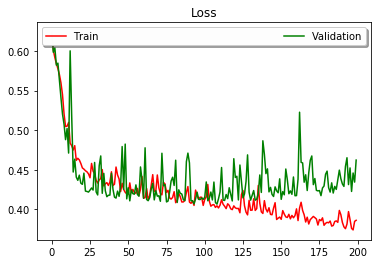

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

x = list(range(len(train_losses)))

ax = plt.subplot(111)
plt.plot(x, train_losses, 'r', label="Train")
plt.plot(x, val_losses, 'g', label="Validation")
plt.title('Loss')
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.99)

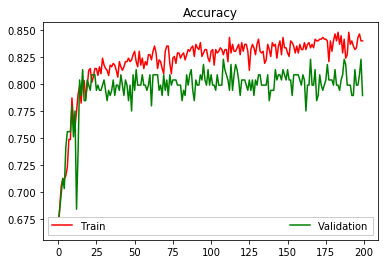

In [44]:
x = list(range(len(train_accuracies)))

ax = plt.subplot(111)
plt.plot(x, train_accuracies, 'r', label="Train")
plt.plot(x, val_accuracies, 'g', label="Validation")
plt.title('Accuracy')
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=False, fancybox=False)
leg.get_frame().set_alpha(0.99)

### Questions: 

<b> a) Que pouvez-vous dire de ces courbes ?  <br/>
Illustrent-ils un régime de sur-apprentissage? Si non, pourquoi? Si oui, que pouvez-vous faire pour y remédier?</b> <br/>
<b> b) Que pouvez-vous faire pour améliorer la performance du réseau de neurones sur des données de validation? </b><br/>

In [45]:
neural_net = load_model(130, neural_net, path='./')

## 5) Évaluer la performance du réseau appris sur des données de Test

Nous pouvons finalement évaluer notre modèle apppris sur notre dataset de Test.

In [46]:
test_loss, test_acc = eval(neural_net, test_loader)

Eval:  Avg_Loss: 0.48241   Acc: 170/209 (81.340%)


### Questions: 

<b> a) Comparer les résultats de validation et de test ?  Le réseau appris généralise t'il aussi bien qu'espéré ? <br/>
b) Pensez-vous qu'il est possible d'utiliser un MLP pour d'autres types de données comme des images par exemple? </b> <br/>